# Identifying customer segments via RFM k-means clustering
## 1. Introduction 
This analysis aims at segmenting a customer base of a UK-based online retailer by employing RFM-based k-means clustering. The utilized datset is available at http://archive.ics.uci.edu/ml/datasets/Online+Retail+II as an .xlsx file and is required to execute the analysis. 
This notebook is structured as follows: Section 2 introduces the dataset and performs a couple of exploratory analyses; Section 3 introduces the RFM terminology and deals with cleaning the data; Section 4 incldues the k-means clustering; Section 5 further segments the clusters using a random forest; Section 6 concludes.

## 2. Introduction to the Dataset and exploratory analyses

In [96]:
# importing standard libraries required for the rest of the notebook. 
# Collecting all required libraries in one cell/ file is common practice in other coding languages and is therefore performed here
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

After loading the dataset and looking at the structure of the set, several observations can be made that are relevant for the analyses that will be performed later: Customers are idetified using a unqiue customer ID while every row represents a distinct purchase of a product at a specific date. Multiple purchases might be associated with one invoice which are distinguished by a unique Invoice ID. 

In [4]:
df = pd.read_excel("online_retail_II.xlsx")
df.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


We perform a couple of exploratory analyses to better understand the structure and quality of the dataset in order to prepare the set for future analyses.

In [19]:
# Understanding the strucutre of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       525461 non-null  object        
 1   StockCode     525461 non-null  object        
 2   Description   522533 non-null  object        
 3   Quantity      525461 non-null  int64         
 4   InvoiceDate   525461 non-null  datetime64[ns]
 5   Price         525461 non-null  float64       
 6   Customer ID   417534 non-null  float64       
 7   Country       525461 non-null  object        
 8   total_amount  525461 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 36.1+ MB


In [20]:
# Looking at value distribution in the dataset
df.describe()

,Quantity,Price,Customer ID,total_amount
count,525461.000000,525461.000000,417534.000000,525461.000000
mean,10.337667,4.688834,15360.645478,18.154506
std,107.424110,146.126914,1680.811316,160.333083
min,-9600.000000,-53594.360000,12346.000000,-53594.360000
25%,1.000000,1.250000,13983.000000,3.750000
50%,3.000000,2.100000,15311.000000,9.950000
75%,10.000000,4.210000,16799.000000,17.700000
max,19152.000000,25111.090000,18287.000000,25111.090000


In [21]:
# counting unique values in the data
df.nunique()

Invoice         28816
StockCode        4632
Description      4681
Quantity          825
InvoiceDate     25296
Price            1606
Customer ID      4383
Country            40
total_amount     5693
dtype: int64

In [22]:
# digging deeper into the origin of the customers to understand the distribution of the customers
countries = df.groupby('Country')
countries.nunique()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,total_amount
Country,,,,,,,,
Australia,50,420,453,44,50,49,15,185
Austria,32,363,379,31,32,36,10,123
Bahrain,8,93,93,12,8,23,2,40
Belgium,65,481,521,31,65,55,17,155
Bermuda,1,34,34,9,1,13,0,17
Brazil,1,61,60,9,1,19,1,37
Canada,2,77,77,10,2,20,1,33
Channel Islands,47,544,573,42,47,54,12,195
Cyprus,25,417,425,30,25,48,7,160


Looking at the descriptive analysis of the data, there are several observations that are relevant for cleaning the data. Those are, chronologically according to the cells above: 
1. it seems like there are records where the price and/ or quantities are below 0. In the context of an online retailer, those transactions most likely represent returns or erroneous transactions. Therefore, we proceed to filter those values out of the dataset as the first step to cleaning the data.
2. There are 40 countries present in the dataset, however, the UK clearly dominates the dataset with 4035 unique customers against a max. of 68 from other countries. Therefore, we propose to restrict filter out all transactions of customers not located in the UK to ensure a sufficient sample size.
3. We also introduce a new column, 'total_amount', that captures the basket value of the transaction which is of primary interest to us in the proceeding analyses.

In [23]:
# introducing an additional column
df['total_amount'] = df.Price * df.Quantity
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [24]:
#Filtering all values which have missing values, represent returns, or are of customers that are not located in the UK.
df.dropna()
df.drop(df[df.total_amount <= 0].index, inplace=True)
df.drop(df[df.Quantity <= 0].index, inplace=True)
df.drop(df[df.Country != "United Kingdom"].index, inplace = True)

In [26]:
df.nunique()

Invoice         19291
StockCode        4241
Description      4510
Quantity          370
InvoiceDate     18015
Price            1262
Customer ID      3969
Country             1
total_amount     4265
dtype: int64

## 3. Introducing the RFM methodology & further pre-processing of the data


The RFM methodology classifies every customer along three dimensions: Recency, Frequency, and Monetary. Those values can then be used to segment customers into relevant segments. 
- *Recency*: Recency is defined as the recency of the last purchase from a defined cut-off date, here the last date available in the dataset. Customers with more recent purchases are likely more attractive as they either represent new or returning customers
- *Frequency*: Frequency is defined as the number of unique purchases that the customers made in the examined timeframe. Customers with a higher frequency tend to be more promising as they shop for a variety of products via the website.
- *Monetary*: Monetary is defined as the total value of purchases made by a customer over the examined timeframe. Customers with a higher monetary value of their purchases are the most profitable ones for the company.

Although this classification has serious drawbacks in practice and greatly simplifies a customer segmentation, it lends itself well to this dataset and still represents one of the longest established methodologies for customer segmentation, especially in the retail space.

We proceed to pre-process the data to gegenrate a target dataset with RFM values for all customers in the cleaned dataset.

In [71]:
# Grouping the dataset on customer ID and calculating values for Recency, Frequency, and Monetary
# the cutoff date is defined as the last date in the 
dataset_cutoff_date = df['InvoiceDate'].max() + timedelta(days=1)
rfm = df.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda x: (dataset_cutoff_date - x.max()).days,
        'Invoice': 'count',
        'total_amount': 'sum'})

In [72]:
rfm.describe()

,InvoiceDate,Invoice,total_amount
count,3969.000000,3969.000000,3969.000000
mean,91.094986,93.456538,1868.167287
std,97.071763,183.306124,7380.830030
min,1.000000,1.000000,2.950000
25%,18.000000,18.000000,304.200000
50%,52.000000,43.000000,669.910000
75%,136.000000,102.000000,1655.640000
max,374.000000,5043.000000,349164.350000


In [73]:
# Renaming the columns to accurately depict the used RFM methodology
rfm.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'total_amount': 'Monetary'}, inplace=True)
rfm.describe()

,Recency,Frequency,Monetary
count,3969.000000,3969.000000,3969.000000
mean,91.094986,93.456538,1868.167287
std,97.071763,183.306124,7380.830030
min,1.000000,1.000000,2.950000
25%,18.000000,18.000000,304.200000
50%,52.000000,43.000000,669.910000
75%,136.000000,102.000000,1655.640000
max,374.000000,5043.000000,349164.350000


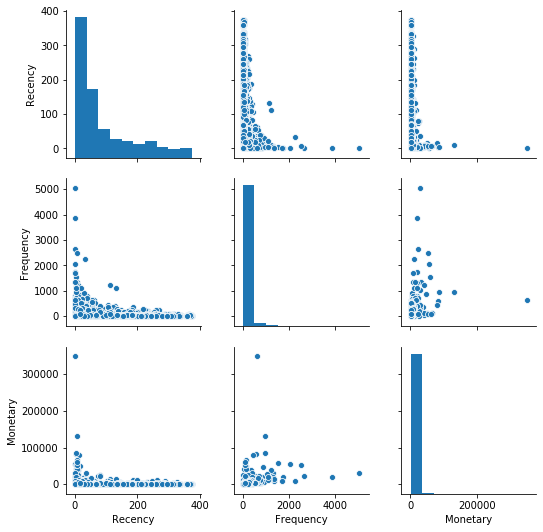

In [74]:
# Visually exploring the distribution of values in the dataset
sns.pairplot(rfm, kind='scatter')

We can see that the dataset includes a couple of extreme outliers. Since we want to emply a k-means classfication on the dataset, we exlude those outliers from the set as to not skew the generated clusters. 

In [75]:
rfm = rfm[rfm.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [76]:
rfm.describe()

,Recency,Frequency,Monetary
count,3903.000000,3903.000000,3903.000000
mean,92.397130,78.940302,1379.247075
std,97.319253,98.464385,2129.453765
min,1.000000,1.000000,2.950000
25%,19.000000,18.000000,299.845000
50%,53.000000,42.000000,651.800000
75%,138.000000,99.000000,1580.135000
max,374.000000,642.000000,23712.310000


Removing the outliers reduced the number of observations by 66,  from 3969 to 3903. We now procede to introduce the k-means classfication on this dataset.

## 4. Generating customer clusters using k-means

To generate customer segments, we proceed as follows: 
1. *Normalization*: Given the distribution & different scaling of the data in the three columns, we normalize the data using robust scaling.
2. *Determining optimal k*: We then try to determine the optimal number of k using multiple approaches, namely the elbow method, the silhouette score, and the Davis Bouldin score.
3. *Generating clusters*: Using that optimal number of k, we segment the dataset into cluster and analyse the results from a business perspective.

In [77]:
# Scaling with Robust Scaler
rfm_model = rfm[['Recency','Frequency','Monetary']]
standar = RobustScaler()
standar.fit(rfm_model)
rfm_model = standar.transform(rfm_model)
rfm_model = pd.DataFrame(rfm_model, columns=['Recency','Frequency','Monetary'])
rfm_model['Customer Id'] = rfm.index
# X_scaled will be used to generate the clusters and features only the target columns
X_scaled = rfm_model[['Recency','Frequency','Monetary']]
X_scaled.describe()

,Recency,Frequency,Monetary
count,3903.000000,3903.000000,3903.000000
mean,0.331068,0.456053,0.568189
std,0.817809,1.215610,1.663259
min,-0.436975,-0.506173,-0.506799
25%,-0.285714,-0.296296,-0.274903
50%,0.000000,0.000000,0.000000
75%,0.714286,0.703704,0.725097
max,2.697479,7.407407,18.011943


Now that we have normalized the dataset, we try to determine the optimal number of k. We employ multiple approaches to triangulate k and increase the accuracy of our model.

In [78]:
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
# for a range of possible k's, we calculate scores and print them out
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=42).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

Score for number of cluster(s) 2: -10463.397090508635
Silhouette score for number of cluster(s) 2: 0.6504380730934459
Davies Bouldin score for number of cluster(s) 2: 0.8167588641412424
Score for number of cluster(s) 3: -7441.4615371714335


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Silhouette score for number of cluster(s) 3: 0.5221767525721336
Davies Bouldin score for number of cluster(s) 3: 0.8508747378222128
Score for number of cluster(s) 4: -5552.047710816524


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Silhouette score for number of cluster(s) 4: 0.4432099779178368
Davies Bouldin score for number of cluster(s) 4: 0.7991045629169259
Score for number of cluster(s) 5: -4328.86385980962


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Silhouette score for number of cluster(s) 5: 0.4456750844884828
Davies Bouldin score for number of cluster(s) 5: 0.865200959500364


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 6: -3535.7448503316105
Silhouette score for number of cluster(s) 6: 0.45038103238377525
Davies Bouldin score for number of cluster(s) 6: 0.8329055719399535


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 7: -3044.4736421234384
Silhouette score for number of cluster(s) 7: 0.4204157541508492
Davies Bouldin score for number of cluster(s) 7: 0.8536857124030357


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 8: -2608.28147728937
Silhouette score for number of cluster(s) 8: 0.42668156693352227
Davies Bouldin score for number of cluster(s) 8: 0.8116581152022959


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 9: -2369.2343765700443
Silhouette score for number of cluster(s) 9: 0.39901591125276353
Davies Bouldin score for number of cluster(s) 9: 0.8558016026475567


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 10: -2158.825516793744
Silhouette score for number of cluster(s) 10: 0.37048021382955754
Davies Bouldin score for number of cluster(s) 10: 0.8760365946782773


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Score for number of cluster(s) 11: -1961.6360570075324
Silhouette score for number of cluster(s) 11: 0.36913415133360633
Davies Bouldin score for number of cluster(s) 11: 0.8606839350992389


C:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


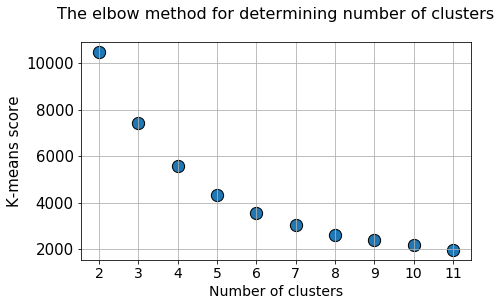

In [79]:
# vidual representation of the elbow method
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

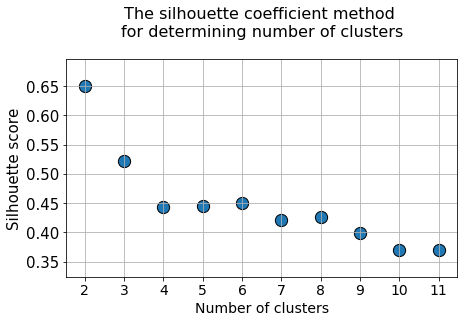

In [80]:
# visual representation of the silhouette coefficient method
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

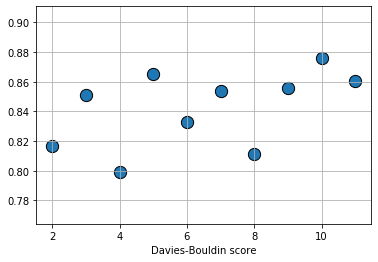

In [81]:
# visual representation of the Davies-Bouldin score
plt.scatter(x=[i for i in range(2,12)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

Based on the calculated and visually observed scores for optimal k, we conclude that the optimal k seems to be 4 which we will now utilize in generating customer segments.

In [82]:
#adding clusters to the dataset
km = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
rfm['cluster'] = km.predict(X_scaled)
X_scaled["cluster"] = km.predict(X_scaled)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


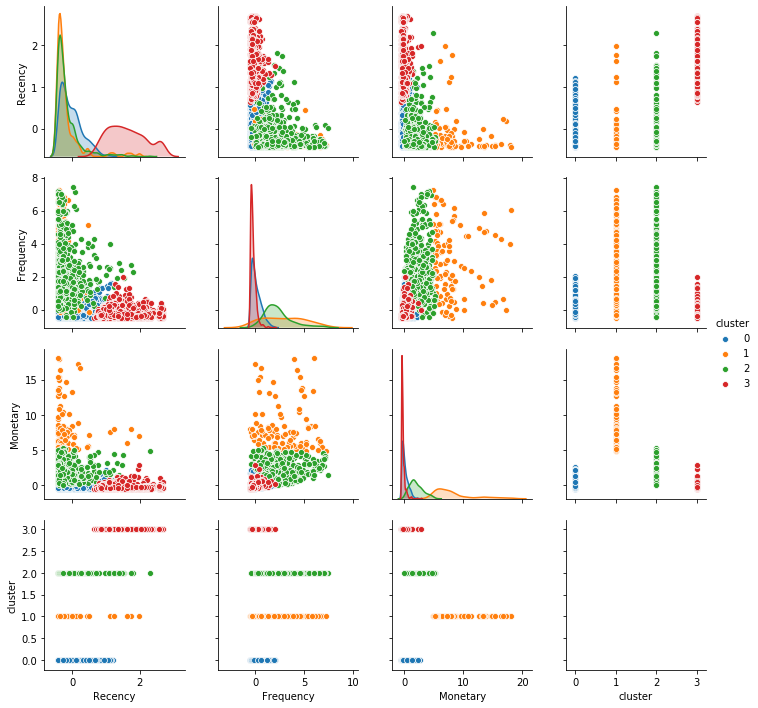

In [83]:
sns.pairplot(X_scaled, kind='scatter', hue='cluster')

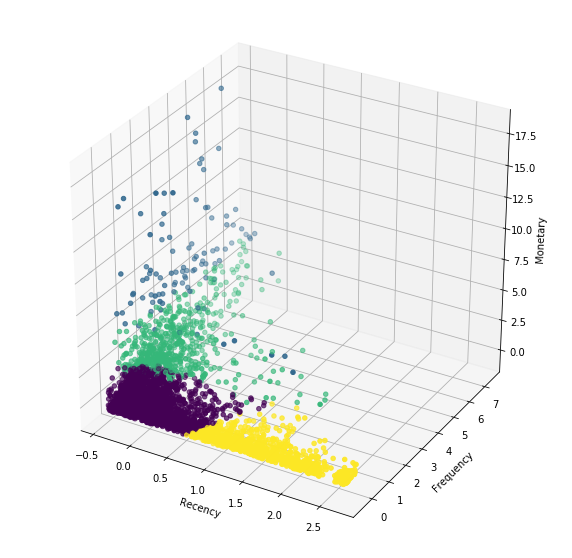

In [99]:
# visualizing the clustering in a 3D-pane
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x_data = X_scaled.Recency
y_data = X_scaled.Frequency
z_data = X_scaled.Monetary
color_data = X_scaled.cluster
ax.scatter(x_data,y_data,z_data, c= color_data)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

## MISSING CONCLUSION (PLEASE FILL)

In [86]:
rfm.reset_index(level=0, inplace=True)

In [87]:
rfm.groupby("cluster").mean()

,Customer ID,Recency,Frequency,Monetary
cluster,,,,
0,15556.490757,49.407570,51.148768,826.752387
1,15336.861386,32.732673,276.504950,11155.803089
2,15483.610932,33.747588,228.491961,3264.640521
3,15651.809471,246.778634,24.058370,382.684354


In [93]:
rfm.describe()

,Customer ID,Recency,Frequency,Monetary,cluster
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,15561.367922,92.397130,78.940302,1379.247075,1.042531
std,1580.411617,97.319253,98.464385,2129.453765,1.292543
min,12346.000000,1.000000,1.000000,2.950000,0.000000
25%,14202.500000,19.000000,18.000000,299.845000,0.000000
50%,15574.000000,53.000000,42.000000,651.800000,0.000000
75%,16938.500000,138.000000,99.000000,1580.135000,2.000000
max,18287.000000,374.000000,642.000000,23712.310000,3.000000
